In [1]:
import boto3
from botocore.config import Config
import json
from openai import OpenAI
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional

In [4]:
df = pd.read_csv("python_wikipedia_questions.csv")

In [5]:
df

,context,question,grounded
0,"Python is a high-level, general-purpose progra...",Which lesser used syntax constructs or 'hidden...,False
1,"Python is a high-level, general-purpose progra...",For Python releases before 3.0 - what were som...,False
2,"Python is a high-level, general-purpose progra...",How suitable is Python for mobile app developm...,False
3,"Python is a high-level, general-purpose progra...","What types of performance gains, architectural...",False
4,"Python is a high-level, general-purpose progra...",How have efforts to introduce optional static ...,False
5,"Python is a high-level, general-purpose progra...","For data analysis, reporting and business inte...",False
6,"Python is a high-level, general-purpose progra...",Which Python databases access libraries seem m...,False
7,"Python is a high-level, general-purpose progra...",How accessible is Python for new programmers v...,False
8,"Python is a high-level, general-purpose progra...",How does Python's concurrency and parallelism ...,False
9,"Python is a high-level, general-purpose progra...",For distributed computing and cloud-native app...,False


In [4]:
def get_bedrock_client(
    assumed_role: Optional[str] = None,
    region: Optional[str] = None,
    runtime: Optional[bool] = True,
):
    """Create a boto3 client for Amazon Bedrock, with optional configuration overrides
    Parameters
    ----------
    assumed_role :
        Optional ARN of an AWS IAM role to assume for calling the Bedrock service. If not
        specified, the current active credentials will be used.
    region :
        Optional name of the AWS Region in which the service should be called (e.g. "us-east-1").
        If not specified, AWS_REGION or AWS_DEFAULT_REGION environment variable will be used.
    runtime :
        Optional choice of getting different client to perform operations with the Amazon Bedrock service.
    """
    if region is None:
        target_region = os.environ.get("AWS_REGION", os.environ.get("AWS_DEFAULT_REGION"))
    else:
        target_region = region

    print(f"Create new client\n  Using region: {target_region}")
    session_kwargs = {"region_name": target_region}
    client_kwargs = {**session_kwargs}

    profile_name = os.environ.get("AWS_PROFILE")
    if profile_name:
        print(f"  Using profile: {profile_name}")
        session_kwargs["profile_name"] = profile_name

    retry_config = Config(
        region_name=target_region,
        retries={
            "max_attempts": 10,
            "mode": "standard",
        },
    )
    session = boto3.Session(**session_kwargs)

    if assumed_role:
        print(f"  Using role: {assumed_role}", end='')
        sts = session.client("sts")
        response = sts.assume_role(
            RoleArn=str(assumed_role),
            RoleSessionName="langchain-llm-1"
        )
        print(" ... successful!")
        client_kwargs["aws_access_key_id"] = response["Credentials"]["AccessKeyId"]
        client_kwargs["aws_secret_access_key"] = response["Credentials"]["SecretAccessKey"]
        client_kwargs["aws_session_token"] = response["Credentials"]["SessionToken"]

    if runtime:
        service_name='bedrock-runtime'
    else:
        service_name='bedrock'

    bedrock_client = session.client(
        service_name=service_name,
        config=retry_config,
        **client_kwargs
    )

    print("boto3 Bedrock client successfully created!")
    print(bedrock_client._endpoint)
    return bedrock_client

In [6]:
"""
Authentication is handled using the AWS_PROFILE environment variable. Check the AWS Boto3 documentation and the provided
utility library for connecting to Bedrock for additional information
"""

bedrock_runtime = get_bedrock_client(region="us-east-1")

In [119]:
openai_client = OpenAI()

In [125]:
def bedrock_invoke(model_id: str, json_request: dict):
    bedrock_response = bedrock_runtime.invoke_model(
        body=json.dumps(json_request), 
        modelId=model_id, 
        accept="*/*", 
        contentType="application/json"
    )
    bedrock_response_json = json.loads(bedrock_response.get("body").read())
    return bedrock_response_json

def prompt_llama(model_id: str, s: str): 
    json_request = {
        "prompt": s,
        "max_gen_len":250,
        "temperature":0.0,
        "top_p":0.9
    }
    response_body = bedrock_invoke(model_id, json_request)
    return response_body.get("generation")

def prompt_cohere(model_id: str, s: str):
    json_request = {
        "message": s
    }
    response_body = bedrock_invoke(model_id, json_request)
    return response_body.get("text")

def prompt_mistral(model_id: str, s: str):
    json_request = {
        "prompt": f"<s>[INST] {s} [/INST]",
        "max_tokens": 250,
        "temperature": 0.0,
        "top_p": 0.9
    }
    response_body = bedrock_invoke(model_id, json_request)
    return response_body.get("outputs")[0].get("text")

def prompt_claude2(model_id: str, s: str):
    json_request = {
        "prompt": f"\n\nHuman: {s}\n\nAssistant:", 
        "max_tokens_to_sample" : 250
    }
    response_body = bedrock_invoke(model_id, json_request)
    return response_body.get("completion")

def prompt_claude3(model_id: str, s: str):
    json_request = {
        "anthropic_version": "bedrock-2023-05-31",
        "max_tokens": 250,
        "messages": [
          {
            "role": "user",
            "content": [
              {
                "type": "text",
                "text": s
              }
            ]
          }
        ]
    }
    response_body = bedrock_invoke(model_id, json_request)
    return response_body.get("content")[0].get("text")

def prompt_gpt(model_id, s: str):
    completion = openai_client.chat.completions.create(
        model=model_id,
        temperature=0.0,
        max_tokens=250,
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": s}
        ]
    )
    return completion.choices[0].message.content

def prompt_titan(model_id: str, s: str):
    json_request = {
        "inputText": s,
        "textGenerationConfig": {
            "maxTokenCount":250,
            "stopSequences":[],
            "temperature":0.0,
            "topP":0.9
        }
    }
    response_body = bedrock_invoke(model_id, json_request)
    return response_body.get("results")[0].get("outputText")

def prompt(model_id: str, s: str):
    if 'llama' in model_id:
        return prompt_llama(model_id, s)
    elif 'cohere' in model_id:
        return prompt_cohere(model_id, s)
    elif 'claude-v2' in model_id:
        return prompt_claude2(model_id, s)
    elif 'claude-3' in model_id:
        return prompt_claude3(model_id, s)
    elif 'mistral' in model_id:
        return prompt_mistral(model_id, s)
    elif 'titan' in model_id:
        return prompt_titan(model_id, s)
    elif 'gpt' in model_id:
        return prompt_gpt(model_id, s)
    else:
        raise ValueError("unrecognized model id")

 # Prompt template

In [42]:
template = """You are a helpful AI assistant. 

You only answer questions about the context you are provided. 

Even if you know the answer, you NEVER provide information or answer any questions about information outside the 'context: ' the user gives you.

context: <context>
question: <question>

Now, answer the question BRIEFLY based on the context. If the question is asking about something not in the context, politely explain that you CANNOT answer the question.
"""

# Run models

In [ ]:
models = [
    "cohere.command-r-plus-v1:0",
    "cohere.command-r-v1:0",
    "meta.llama3-8b-instruct-v1:0",
    "meta.llama3-70b-instruct-v1:0",
    "mistral.mistral-7b-instruct-v0:2",
    "mistral.mixtral-8x7b-instruct-v0:1",
    "mistral.mistral-large-2402-v1:0",
    "anthropic.claude-3-sonnet-20240229-v1:0",
    "anthropic.claude-3-haiku-20240307-v1:0",
    "amazon.titan-text-express-v1",
    "amazon.titan-text-lite-v1",
    "gpt-3.5-turbo-16k-0613",
    "gpt-3.5-turbo-1106",
    "gpt-3.5-turbo-0125",
    "gpt-4-1106-preview",
    "gpt-4-0125-preview",
    "gpt-4-turbo-2024-04-09"
]

In [18]:
for m in models:
    print("----------------\n", m, "----------------\n")
    df[m] = ['']*len(df)
    for i, row in df.iterrows():
        print(row.question)
        filled_prompt = template.replace("<context>", row.context).replace("<question>", row.question)
        response = prompt(m, filled_prompt)
        print(response)
        df.loc[i, m] = response
        df.to_csv("ungraded_results.csv", index=False)

# We separately graded these results manually 

Each response gets one of the following scores:

- `grounded_correct`
- `grounded_incorrect`
- `ungrounded_correct`
- `ungrounded_incorrect`
- `incoherent`

In [30]:
graded_df_withna = pd.read_csv("graded_python_wikipedia_answers.csv")
graded_df = graded_df_withna.dropna()

In [31]:
graded_df

,context,question,answerable,cohere.command-r-plus-v1:0,cohere.command-r-plus-v1:0_score,cohere.command-r-v1:0,cohere.command-r-v1:0_score,meta.llama3-8b-instruct-v1:0,meta.llama3-8b-instruct-v1:0_score,meta.llama3-70b-instruct-v1:0,...,gpt-3.5-turbo-1106,gpt-3.5-turbo-1106_score,gpt-3.5-turbo-0125,gpt-3.5-turbo-0125_score,gpt-4-1106-preview,gpt-4-1106-preview_score,gpt-4-0125-preview,gpt-4-0125-preview_score,gpt-4-turbo-2024-04-09,gpt-4-turbo-2024-04-09_score
0,"Python is a high-level, general-purpose progra...",Which lesser used syntax constructs or 'hidden...,False,I cannot answer this question as the context p...,grounded_correct,Some lesser-used syntax constructs in Python i...,grounded_correct,```\nI cannot answer questions about informati...,grounded_correct,```\nI cannot answer this question as it is as...,...,"I'm sorry, I cannot answer that question based...",grounded_correct,"I'm sorry, but I cannot provide an answer to t...",grounded_correct,The context provided does not include specific...,grounded_correct,"I'm sorry, but the context provided does not i...",grounded_correct,The context provided does not include specific...,grounded_correct
1,"Python is a high-level, general-purpose progra...",For Python releases before 3.0 - what were som...,False,I cannot answer this question as the context p...,grounded_correct,The biggest compatibility breakages in Python ...,ungrounded_correct,```\nI can answer this question briefly based ...,grounded_incorrect,```\nI cannot answer this question as it is no...,...,"I'm sorry, I cannot answer that question based...",grounded_correct,Some of the biggest compatibility breakages an...,ungrounded_correct,The context provided does not include specific...,grounded_correct,The context provided does not specifically det...,grounded_correct,The context provided does not include specific...,grounded_correct
2,"Python is a high-level, general-purpose progra...",How suitable is Python for mobile app developm...,False,I cannot answer this question as the context p...,grounded_correct,The context provided does not explicitly menti...,ungrounded_correct,```\nI cannot provide information on mobile ap...,grounded_correct,```\nI cannot answer this question as it is no...,...,"Python is suitable for mobile app development,...",ungrounded_correct,Python is not typically the first choice for m...,ungrounded_correct,The context provided does not include specific...,grounded_correct,The context provided does not include specific...,grounded_correct,The context provided does not include specific...,grounded_correct
3,"Python is a high-level, general-purpose progra...","What types of performance gains, architectural...",False,I cannot answer this question as the context p...,grounded_correct,"According to the context you provided, Python ...",grounded_correct,```\nI cannot provide information on the conte...,ungrounded_correct,```\nI cannot answer this question as it is as...,...,"I'm sorry, I cannot answer that question based...",grounded_correct,"Based on the context provided, for Python to d...",ungrounded_correct,The context provided does not include specific...,grounded_correct,"To displace dominant languages like C++, Java,...",ungrounded_correct,The context provided does not include specific...,grounded_correct
4,"Python is a high-level, general-purpose progra...",How have efforts to introduce optional static ...,False,I cannot answer this question as the context p...,grounded_correct,I cannot comment on the effects of optional st...,grounded_correct,```\nI can answer this question briefly. Accor...,ungrounded_incorrect,```\nI cannot answer this question as it is no...,...,"I'm sorry, but I cannot answer that question b...",grounded_correct,Efforts to introduce optional static type anno...,ungrounded_correct,The context provided does not contain specific...,grounded_correct,The context provided does not specifically add...,grounded_correct,The context provided does not include specific...,ground

In [10]:
def plot_model_scores(graded_df):
    """
    Plot model scores sorted by grounded_correct
    """
    model_columns = {m : f"{m}_score" for m in models}

    def calculate_percentage(score_col, score_types):
        return (graded_df[score_col].isin(score_types).sum() / len(graded_df)) * 100

    grounded_correct = {model: calculate_percentage(score_col, ['grounded_correct']) for model, score_col in model_columns.items()}
    grounded = {model: calculate_percentage(score_col, ['grounded_correct', 'grounded_incorrect']) for model, score_col in model_columns.items()}
    correct = {model: calculate_percentage(score_col, ['grounded_correct', 'ungrounded_correct']) for model, score_col in model_columns.items()}

    sorted_models = sorted(grounded_correct, key=grounded_correct.get, reverse=True)
    grounded_correct_sorted = [grounded_correct[model] for model in sorted_models]
    grounded_sorted = [grounded[model] for model in sorted_models]
    correct_sorted = [correct[model] for model in sorted_models]

    fig, axes = plt.subplots(3, 1, figsize=(15, 15))
    lists = [grounded_correct_sorted, grounded_sorted, correct_sorted]
    colors = ['green', 'orange', 'purple']
    titles = ['Grounded Correct (%)', 'Grounded (%)', 'Correct (%)']
    for i, (title, l, color) in enumerate(zip(titles, lists, colors)):
        axes[i].grid(linestyle='dashed')
        axes[i].bar(sorted_models, l, color=color, width=0.5, zorder=3)
        axes[i].set_title(title)
        axes[i].set_ylabel('%')
        axes[i].set_xticks(np.arange(len(sorted_models)))
        axes[i].set_xticklabels(sorted_models, rotation=80, fontsize=7)
        

    plt.tight_layout()
    plt.show()

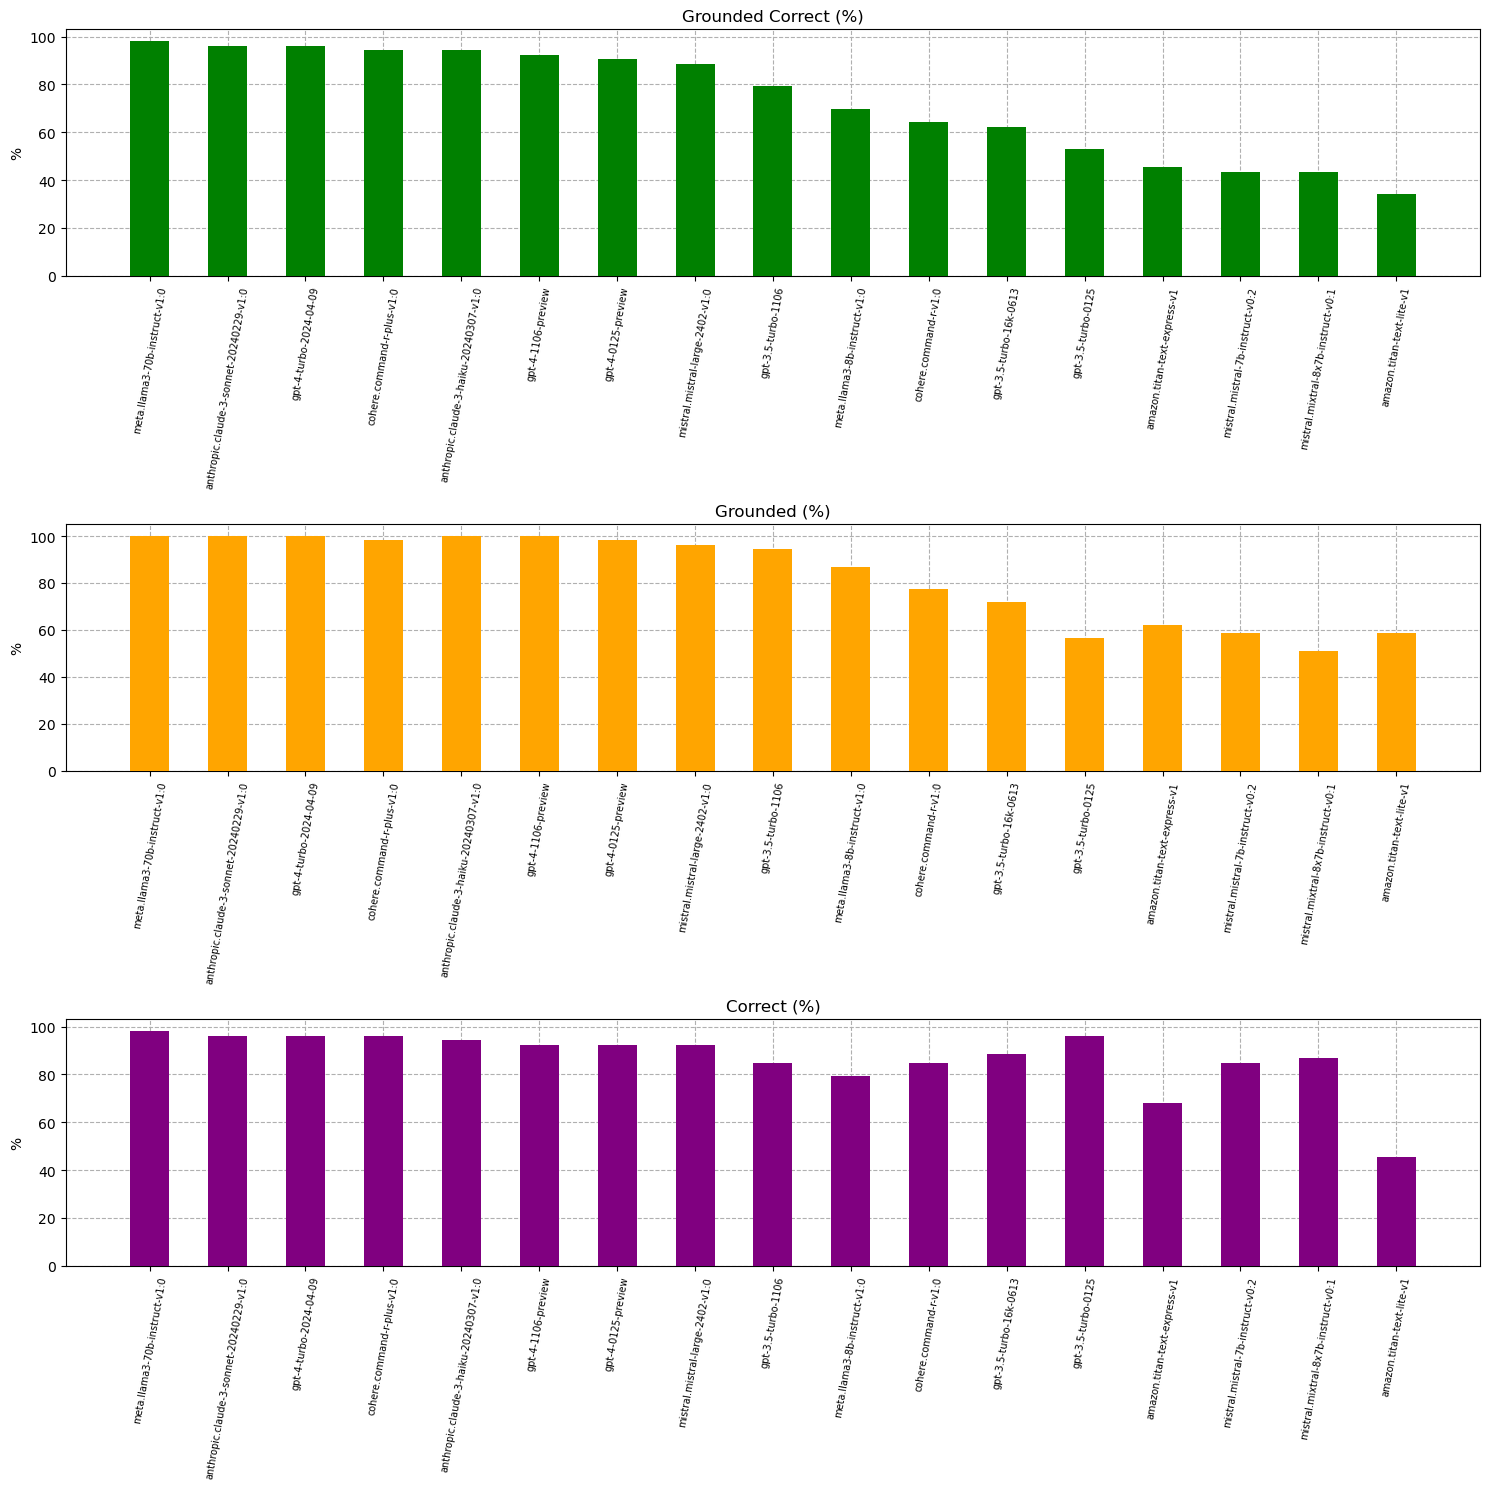

In [13]:
plot_model_scores(graded_df)

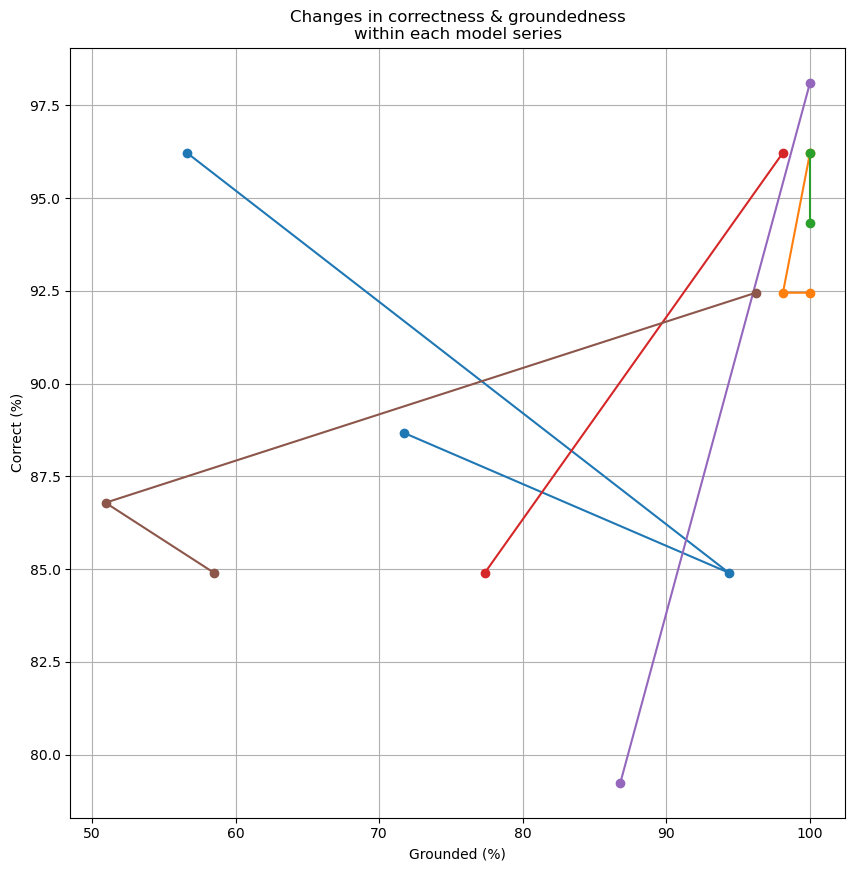

In [14]:
def plot_series_trajectory(graded_df, series_names):
    model_columns = {m: f"{m}_score" for m in models}

    def calculate_percentage(score_col, score_types):
        return (graded_df[score_col].isin(score_types).sum() / len(graded_df)) * 100

    grounded_correct = {model: calculate_percentage(score_col, ['grounded_correct']) for model, score_col in model_columns.items()}
    grounded = {model: calculate_percentage(score_col, ['grounded_correct', 'grounded_incorrect']) for model, score_col in model_columns.items()}
    correct = {model: calculate_percentage(score_col, ['grounded_correct', 'ungrounded_correct']) for model, score_col in model_columns.items()}

    fig, ax = plt.subplots(figsize=(10, 10))
    
    final = []
    
    for names in series_names:
        xs, ys = [], []
        for n in names:
            xs.append(grounded[n])
            ys.append(correct[n])
            final.append({""})
        ax.plot(xs, ys, marker='o', linestyle='-')

    ax.set_xlabel('Grounded (%)')
    ax.set_ylabel('Correct (%)')
    ax.set_title('Changes in correctness & groundedness\nwithin each model series')
    ax.grid(True)
    plt.show()
    
series_names = [
    [
        "gpt-3.5-turbo-16k-0613",
    "gpt-3.5-turbo-1106",
    "gpt-3.5-turbo-0125",
    ],
    [
        "gpt-4-1106-preview",
    "gpt-4-0125-preview",
    "gpt-4-turbo-2024-04-09"
    ],
    [
        "anthropic.claude-3-sonnet-20240229-v1:0",
    "anthropic.claude-3-haiku-20240307-v1:0",
    ],
    [
        "cohere.command-r-plus-v1:0",
    "cohere.command-r-v1:0",
    ],
    [
        "meta.llama3-8b-instruct-v1:0",
    "meta.llama3-70b-instruct-v1:0",
    ],
    [
        "mistral.mistral-7b-instruct-v0:2",
    "mistral.mixtral-8x7b-instruct-v0:1",
    "mistral.mistral-large-2402-v1:0",
    ]
]
plot_series_trajectory(graded_df, series_names)

# Measuring cost & latency

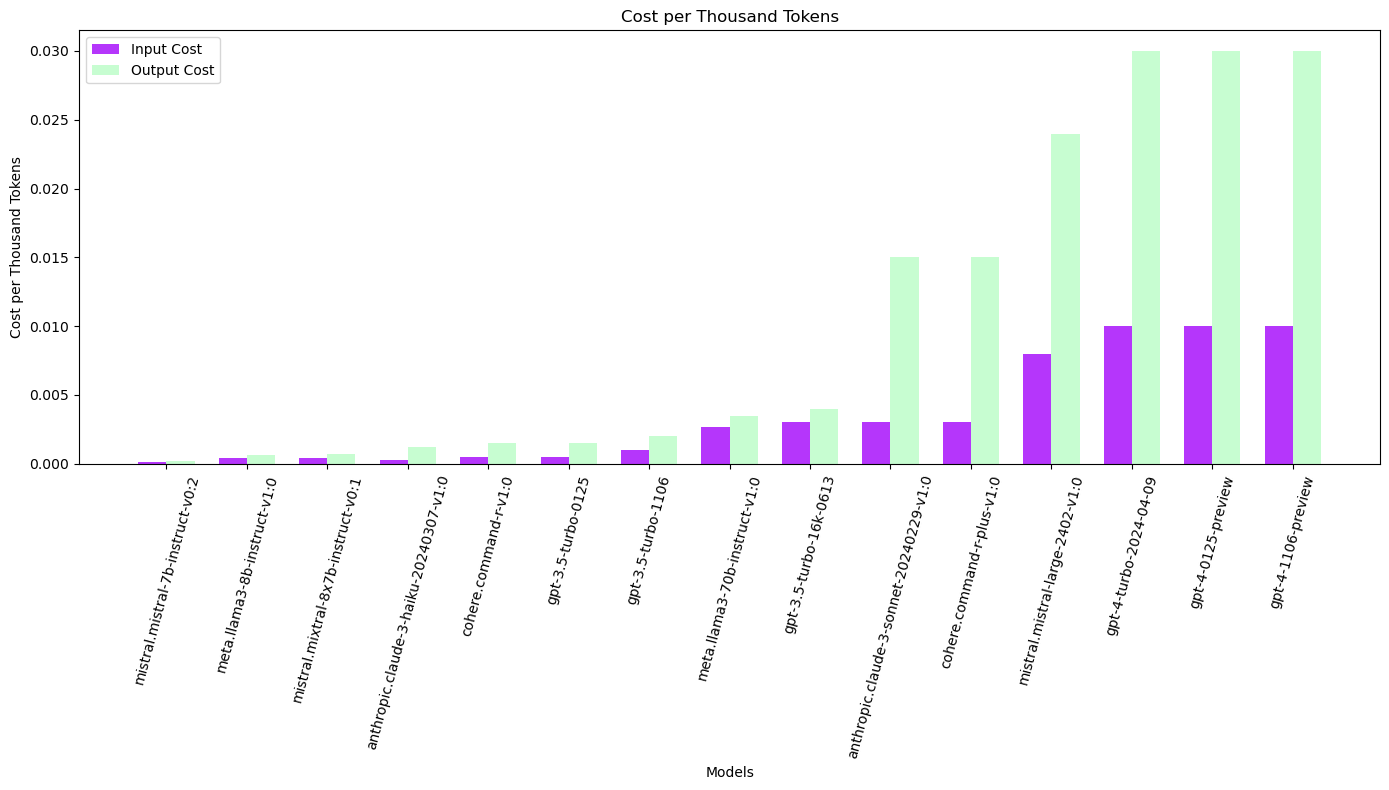

In [17]:
cost_per_thousand_tokens = {
    "anthropic.claude-3-sonnet-20240229-v1:0": {"in": 0.003, "out": 0.015},
    "anthropic.claude-3-haiku-20240307-v1:0": {"in": 0.00025, "out": 0.00125},
    "cohere.command-r-plus-v1:0": {"in": 0.003, "out": 0.015},
    "cohere.command-r-v1:0": {"in": 0.0005, "out": 0.0015},
    "gpt-4-turbo-2024-04-09": {"in": 0.01, "out": 0.03},
    "gpt-4-0125-preview": {"in": 0.01, "out": 0.03},
    "gpt-4-1106-preview": {"in": 0.01, "out": 0.03},
    "gpt-3.5-turbo-0125": {"in": 0.0005, "out": 0.0015},
    "gpt-3.5-turbo-1106": {"in": 0.001, "out": 0.002},
    "gpt-3.5-turbo-16k-0613": {"in": 0.003, "out": 0.004},
    "meta.llama3-8b-instruct-v1:0": {"in": 0.0004, "out": 0.0006},
    "meta.llama3-70b-instruct-v1:0": {"in": 0.00265, "out": 0.0035},
    "mistral.mistral-7b-instruct-v0:2": {"in": 0.00015, "out": 0.0002},
    "mistral.mixtral-8x7b-instruct-v0:1": {"in": 0.00045, "out": 0.0007},
    "mistral.mistral-large-2402-v1:0": {"in": 0.008, "out": 0.024},
}

# sort by output cost
sorted_items = sorted(cost_per_thousand_tokens.items(), key=lambda item: item[1]['out'])

labels = [item[0] for item in sorted_items]
input_costs = [item[1]['in'] for item in sorted_items]
output_costs = [item[1]['out'] for item in sorted_items]

x = np.arange(len(labels))
width = 0.35

input_color = "#B536FB"
output_color = "#C7FDD1"

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width/2, input_costs, width, label='Input Cost', color=input_color)
rects2 = ax.bar(x + width/2, output_costs, width, label='Output Cost', color=output_color)

ax.set_xlabel('Models')
ax.set_ylabel('Cost per Thousand Tokens')
ax.set_title('Cost per Thousand Tokens')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=75, ha="center")

ax.legend()

fig.tight_layout()

plt.show()

# Now estimate the actual experiment cost by integrating each model's input/output volume, tokenizer processing, and token pricing

In [20]:
import tiktoken
from transformers import AutoTokenizer
cohere_tokenizer = AutoTokenizer.from_pretrained("CohereForAI/c4ai-command-r-plus")
tiktoken_tokenizer = tiktoken.get_encoding("cl100k_base")
llama_tokenizer = AutoTokenizer.from_pretrained(
    "NousResearch/Meta-Llama-3-8B-Instruct"
)
mistral_tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [40]:
cost_per_thousand_tokens = {
    "anthropic.claude-3-sonnet-20240229-v1:0": {
        "in": 0.003, 
        "out": 0.015, 
        "tokenizer": tiktoken_tokenizer
    },
    "anthropic.claude-3-haiku-20240307-v1:0": {
        "in": 0.00025, 
        "out": 0.00125,
        "tokenizer": tiktoken_tokenizer
    },
    "cohere.command-r-plus-v1:0": {
        "in": 0.003, 
        "out": 0.015,
        "tokenizer": cohere_tokenizer
    },
    "cohere.command-r-v1:0": {
        "in": 0.0005, 
        "out": 0.0015,
        "tokenizer": cohere_tokenizer
    },
    "gpt-4-turbo-2024-04-09": {
        "in": 0.01, 
        "out": 0.03,
        "tokenizer": tiktoken_tokenizer
    },
    "gpt-4-0125-preview": {
        "in": 0.01, 
        "out": 0.03,
        "tokenizer": tiktoken_tokenizer
    },
    "gpt-4-1106-preview": {
        "in": 0.01, 
        "out": 0.03,
        "tokenizer": tiktoken_tokenizer
    },
    "gpt-3.5-turbo-0125": {
        "in": 0.0005, 
        "out": 0.0015,
        "tokenizer": tiktoken_tokenizer
    },
    "gpt-3.5-turbo-1106": {
        "in": 0.001, 
        "out": 0.002,
        "tokenizer": tiktoken_tokenizer
    },
    "gpt-3.5-turbo-16k-0613": {
        "in": 0.003, 
        "out": 0.004,
        "tokenizer": tiktoken_tokenizer
    },
    "meta.llama3-8b-instruct-v1:0": {
        "in": 0.0004, 
        "out": 0.0006,
        "tokenizer": llama_tokenizer
    },
    "meta.llama3-70b-instruct-v1:0": {
        "in": 0.00265, 
        "out": 0.0035,
        "tokenizer": llama_tokenizer
    },
    "mistral.mistral-7b-instruct-v0:2": {
        "in": 0.00015, 
        "out": 0.0002,
        "tokenizer": mistral_tokenizer
    },
    "mistral.mixtral-8x7b-instruct-v0:1": {
        "in": 0.00045, 
        "out": 0.0007,
        "tokenizer": mistral_tokenizer
    },
    "mistral.mistral-large-2402-v1:0": {
        "in": 0.008, 
        "out": 0.024,
        "tokenizer": mistral_tokenizer
    },
}

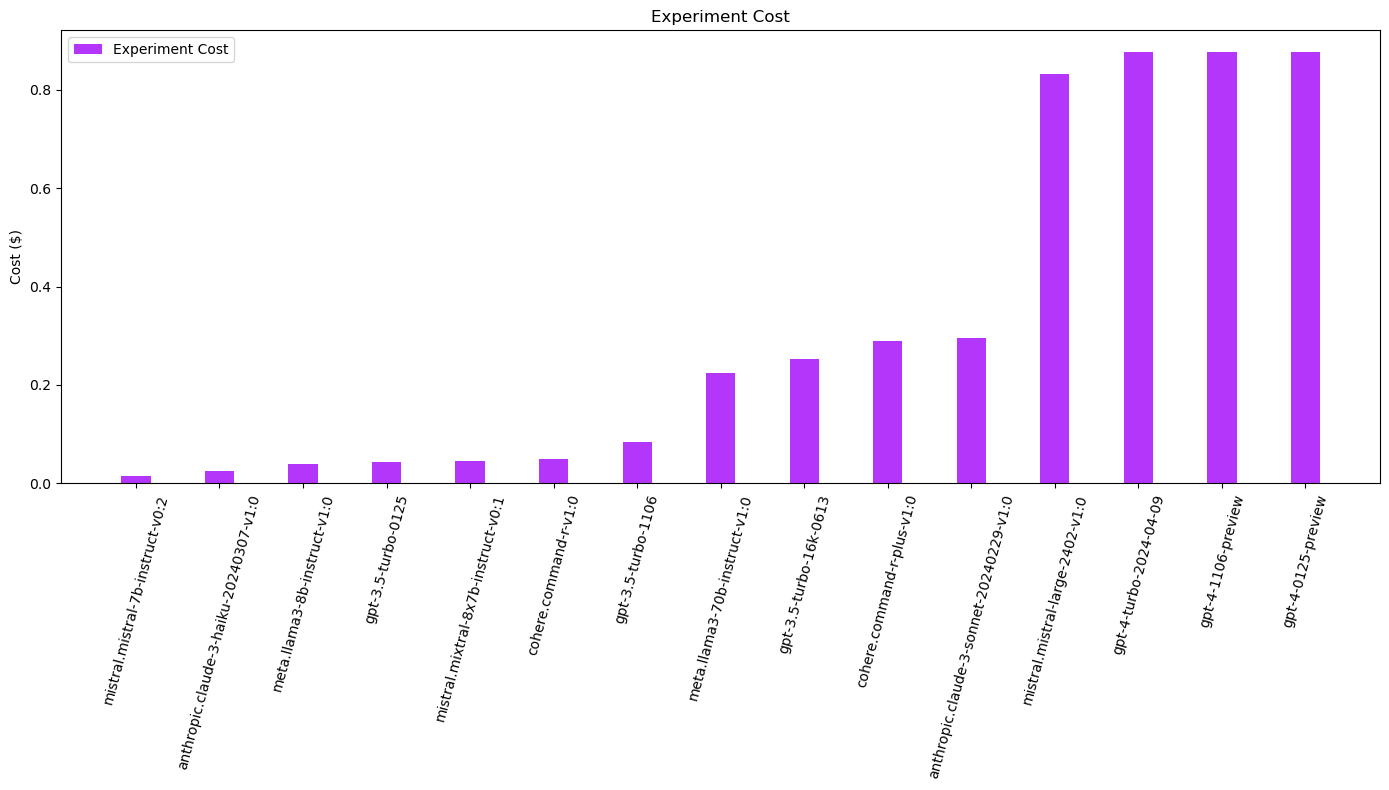

In [49]:
def calculate_costs(data, model_info):
    model_col = data[model].values
    context_col = data['context'].values
    question_col = data['question'].values
    tokenizer = model_info['tokenizer']
    num_inputs, num_outputs = [], []
    for question, context, output in zip(question_col, context_col, model_col):
        filled_prompt = template.replace("<context>", context).replace("<question>", question)
        num_inputs.append(len(tokenizer.encode(filled_prompt)))
        num_outputs.append(len(tokenizer.encode(output)))
    input_cost = sum(num_inputs) * model_info['in']
    output_cost = sum(num_outputs) * model_info['out']
    return (input_cost + output_cost) / 1000

total_costs = []
labels = []
for model, info in cost_per_thousand_tokens.items():
    cost = calculate_costs(graded_df, info)
    total_costs.append(cost)
    labels.append(model)
    
sorted_indices = np.argsort(total_costs)
sorted_costs = np.array(total_costs)[sorted_indices]
sorted_labels = np.array(labels)[sorted_indices]

x = np.arange(len(sorted_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
rects = ax.bar(x, sorted_costs, width, label='Experiment Cost', color='#B536FB')

ax.set_ylabel('Cost ($)')
ax.set_title('Experiment Cost')
ax.set_xticks(x)
ax.set_xticklabels(sorted_labels, rotation=75, ha="center")
ax.legend()

fig.tight_layout()
plt.show()